In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from synthetic_data_scripts import compute_synthetic_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import hospitalization rates from RESCEU
hosp_rates = pd.read_csv("./RESCEU_total_hosp_rates.csv")

# import population estimates from Eurostat
population = pd.read_csv("../../auxiliary-data/population/raw-data/population_estimates_extended.csv")

# import reference season
reference_season = pd.read_csv("./reference_season.csv")

In [3]:
countries_with_data = [c for c in population.country.unique() if c in hosp_rates.country.unique()]

df_weekly_hospitalizations = pd.DataFrame()
df_total_hospitalizations_ages = pd.DataFrame()

for country in countries_with_data:

    df_curve = compute_synthetic_curve(country, hosp_rates, population, reference_season)
    df_curve.rename(columns={"age_group": "age_group_extended"}, inplace=True)

    # group extended age groups to match the ones relevant for the scenario
    # 0-2mo, 3-5mo, 6-11mo, 1-4y, 5-64y, 65+y
    df_curve["age_group"] = df_curve["age_group_extended"].copy()
    df_curve.loc[df_curve.age_group_extended.isin(['12-35mo', '36-59mo']), "age_group"] = "1-4y"
    df_curve.loc[df_curve.age_group_extended.isin(['5-17y','18-64y']), "age_group"] = "5-64y"
    df_curve.loc[df_curve.age_group_extended.isin(['65-74y', '75-84y', '85+y']), "age_group"] = "65+y"
    df_curve.drop(columns=["age_group_extended"], inplace=True)
    df_curve = df_curve.groupby(["country", "age_group", "week"], as_index=False).hospitalizations.sum()

    # add date that matches the scenario period 
    df_curve["year"] = 2025
    df_curve.loc[df_curve["week"] < 27, "year"] = 2026
    df_curve["date"] = pd.to_datetime(df_curve["year"].astype(str) + "-" + df_curve["week"].astype(str) + "-1", format="%G-%V-%u")
    df_curve = df_curve.loc[(df_curve.date >= "2025-09-01") & (df_curve.date <= "2026-04-30")]
    df_curve.sort_values(by=["country", "age_group", "date"], inplace=True)

    # compute total weekly hospitalizations for each country
    df_curve_total = df_curve.groupby(["country", "week", "year", "date"], as_index=False).hospitalizations.sum()
    df_curve_total.insert(1, "age_group", "total")
    df_curve_total.sort_values(by=["date"], inplace=True, ignore_index=True)

    # compute total burden per age group
    df_burden_ages = df_curve.groupby(["country", "age_group"], as_index=False).hospitalizations.sum()

    # concatenate results
    df_weekly_hospitalizations = pd.concat([df_weekly_hospitalizations, df_curve_total], ignore_index=True)
    df_total_hospitalizations_ages = pd.concat([df_total_hospitalizations_ages, df_burden_ages], ignore_index=True)

# add year_week column
df_weekly_hospitalizations["year_week"] = df_weekly_hospitalizations["year"].astype(str) + "-W" + df_weekly_hospitalizations["week"].astype(str)

# reorder columns
df_weekly_hospitalizations = df_weekly_hospitalizations[["country", "age_group", "date", "year_week", "week", "year", "hospitalizations"]]

# order rows
df_total_hospitalizations_ages['order_cat'] = pd.Categorical(df_total_hospitalizations_ages['age_group'], 
                                                             categories=['0-2mo', '3-5mo', '6-11mo', '1-4y', '5-64y', '65+y'], ordered=True)
df_total_hospitalizations_ages.sort_values(['country', 'order_cat'], inplace=True, ignore_index=True)
df_total_hospitalizations_ages.drop(columns=['order_cat'], inplace=True)

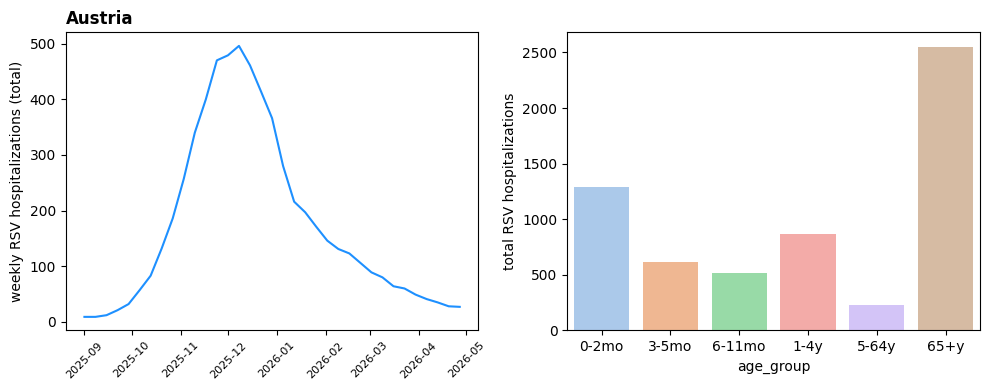

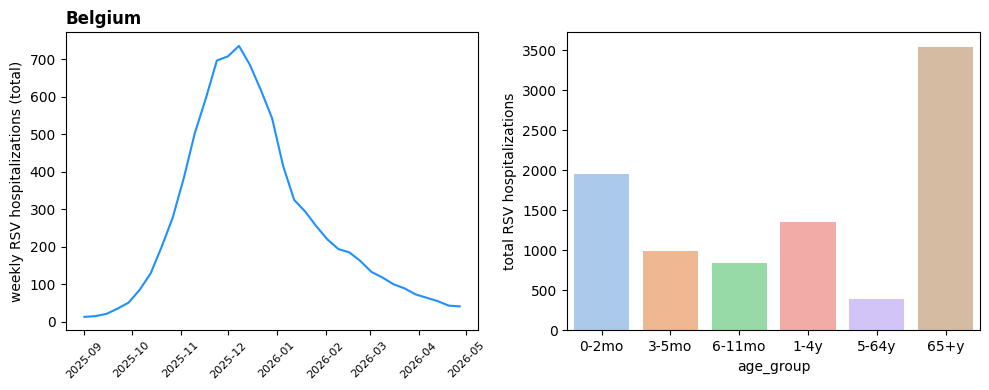

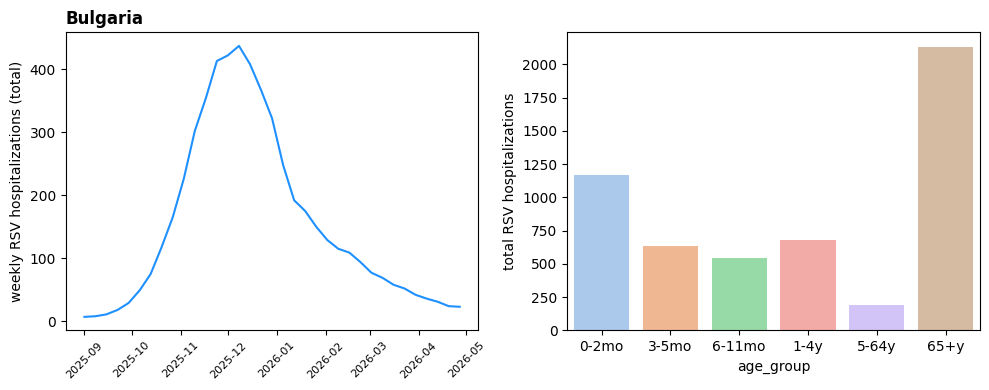

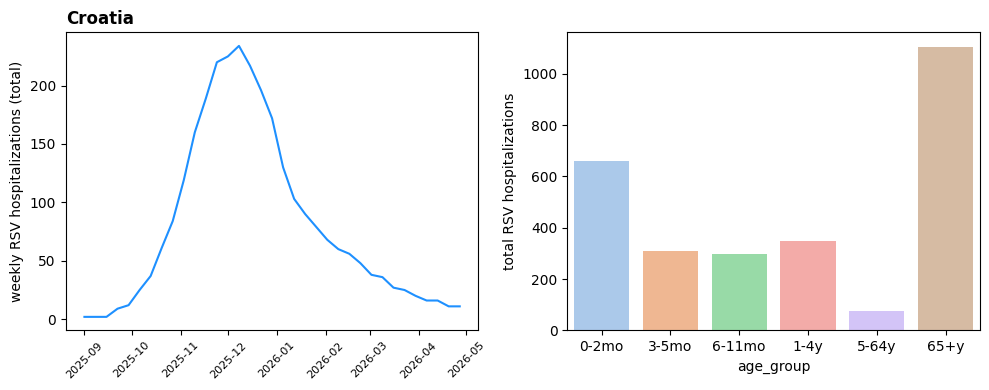

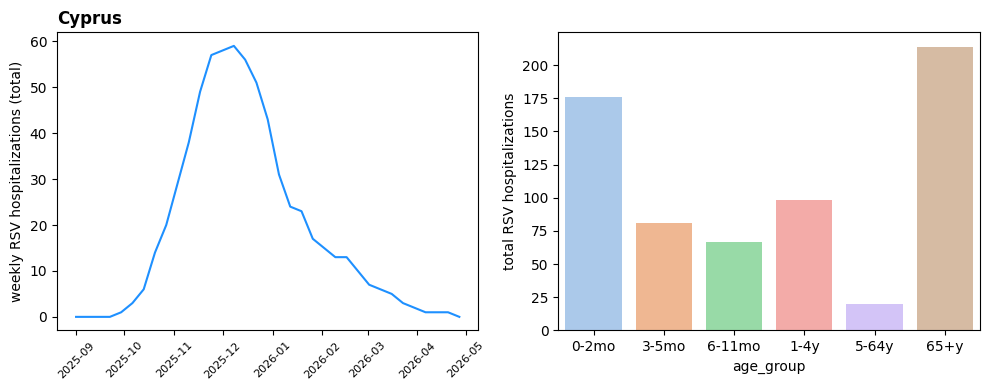

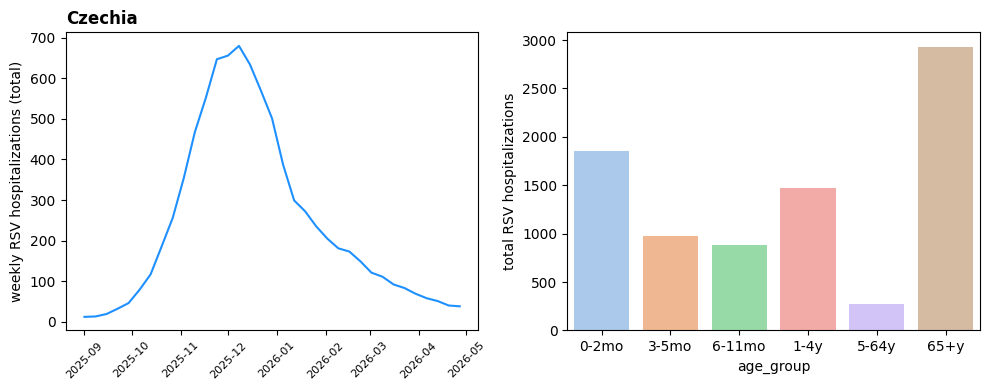

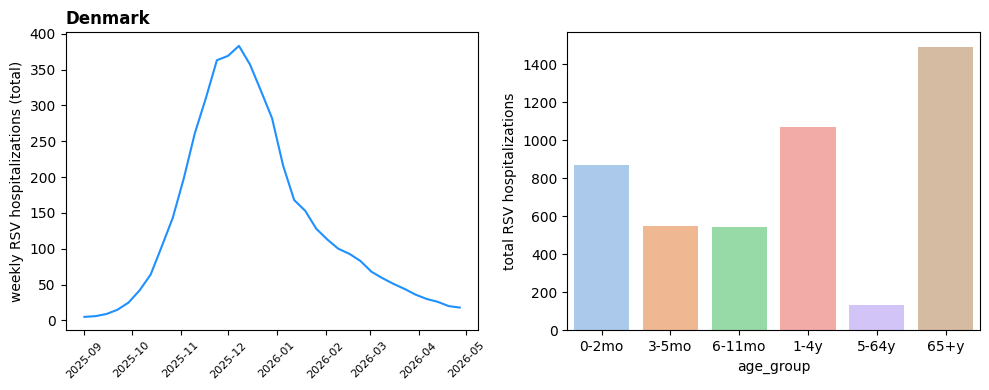

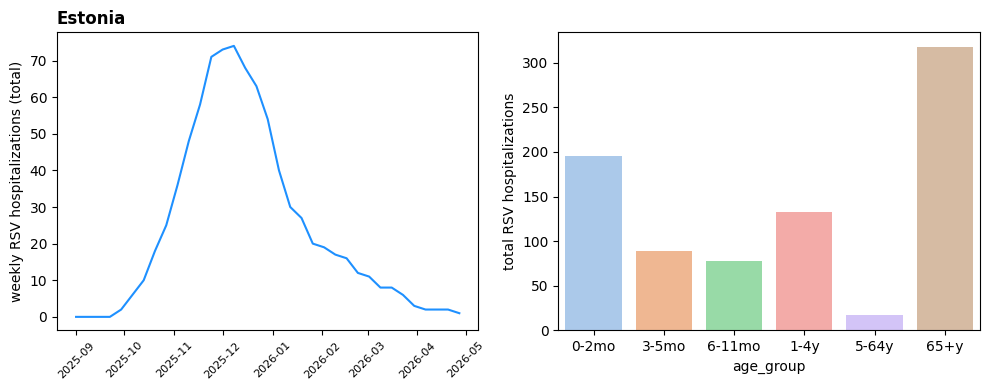

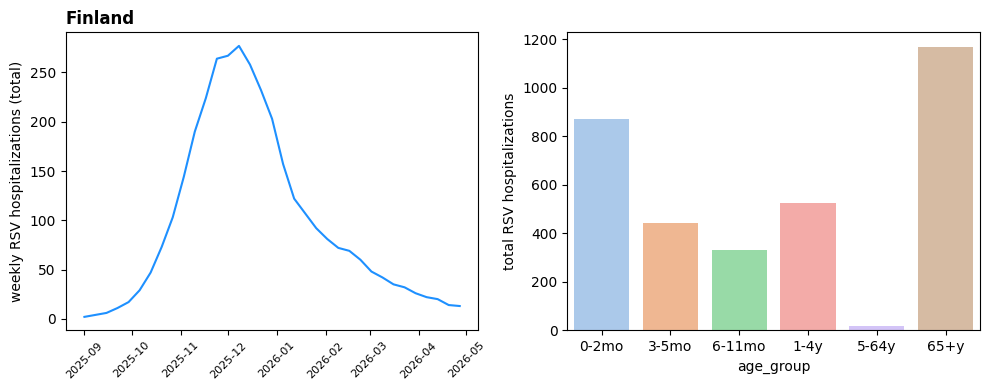

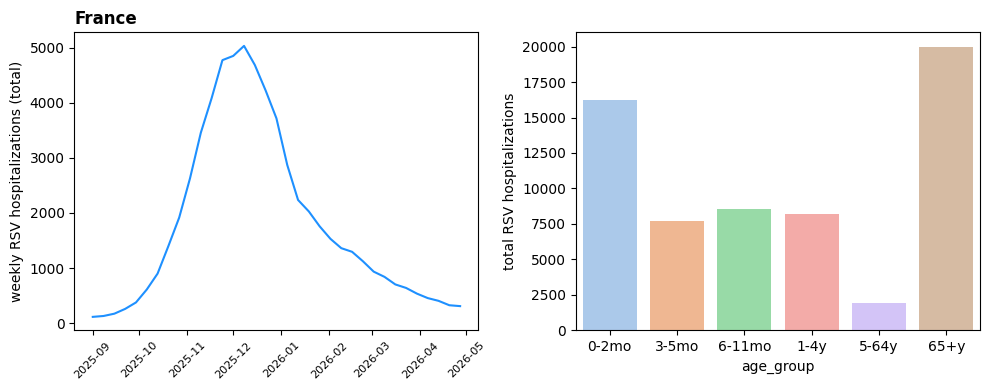

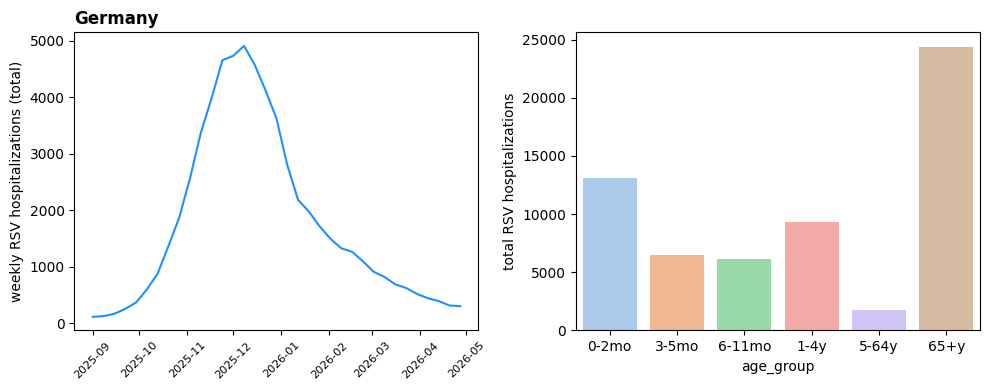

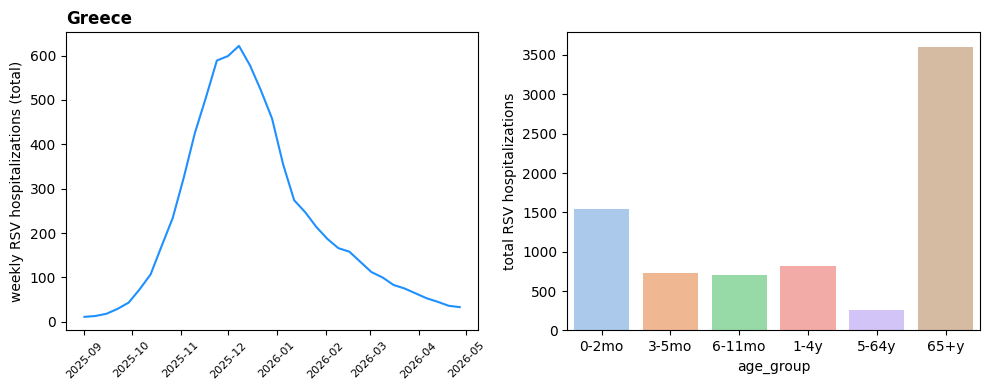

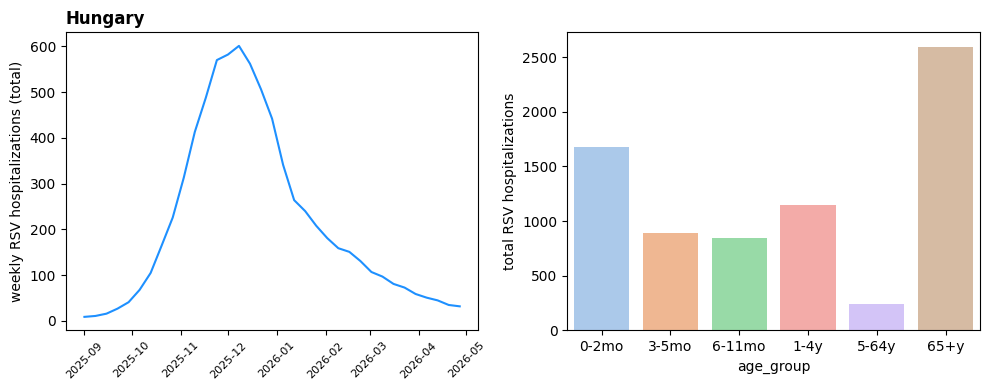

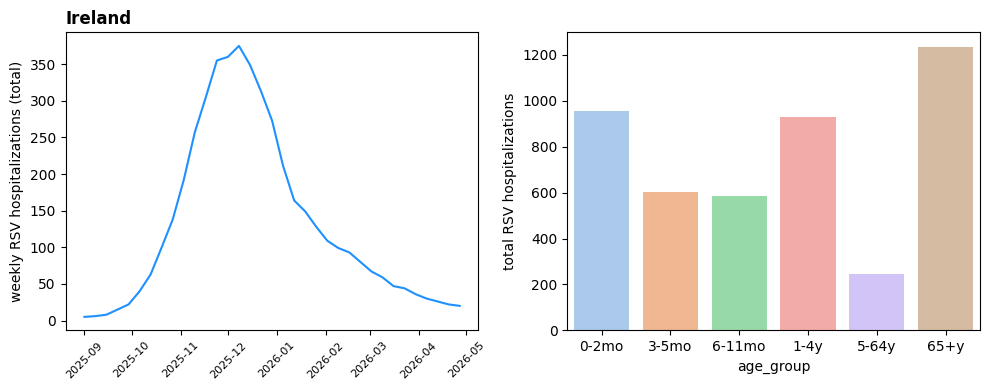

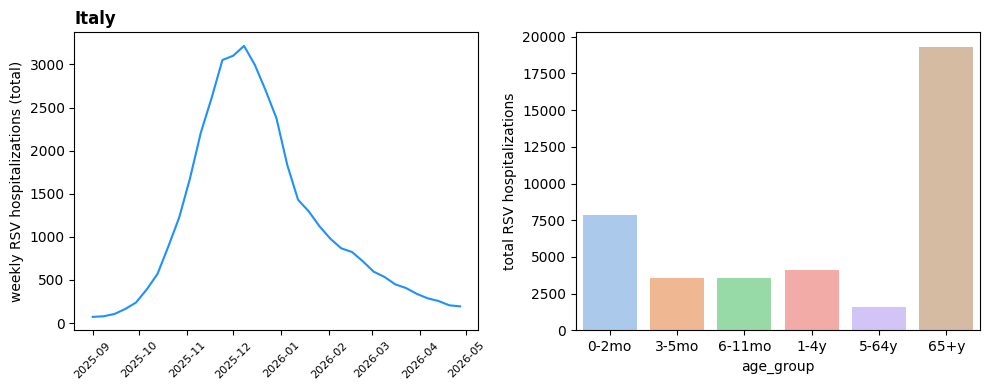

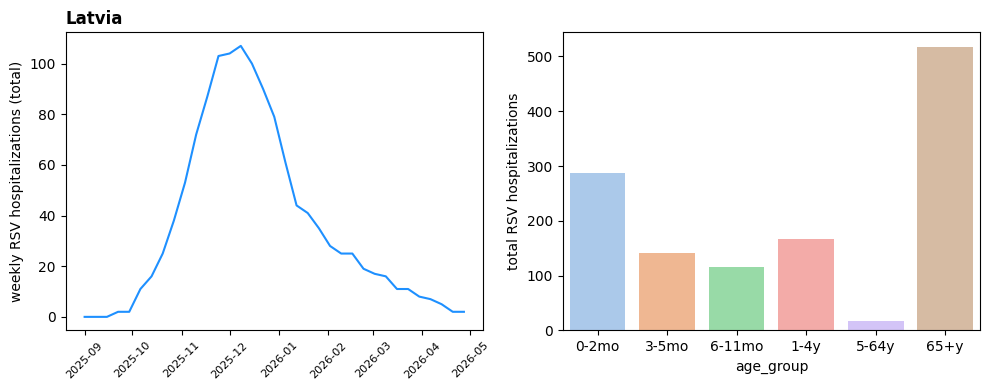

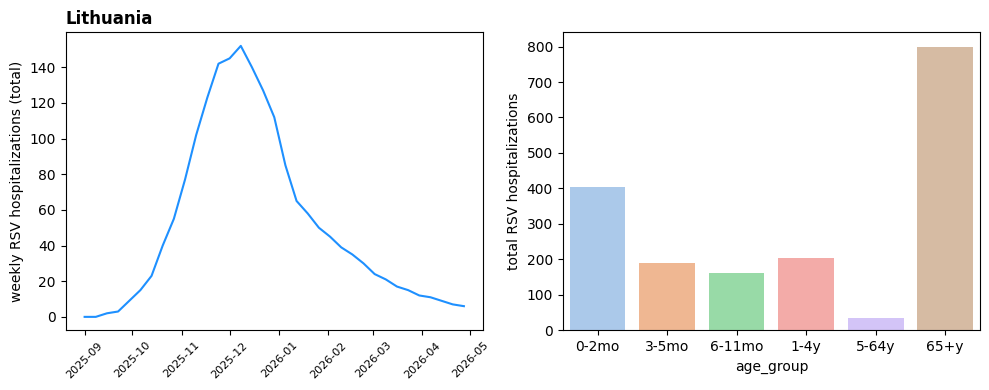

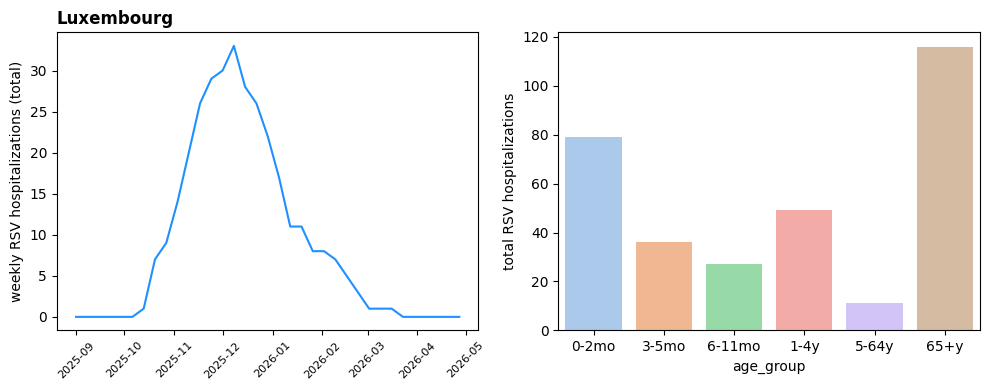

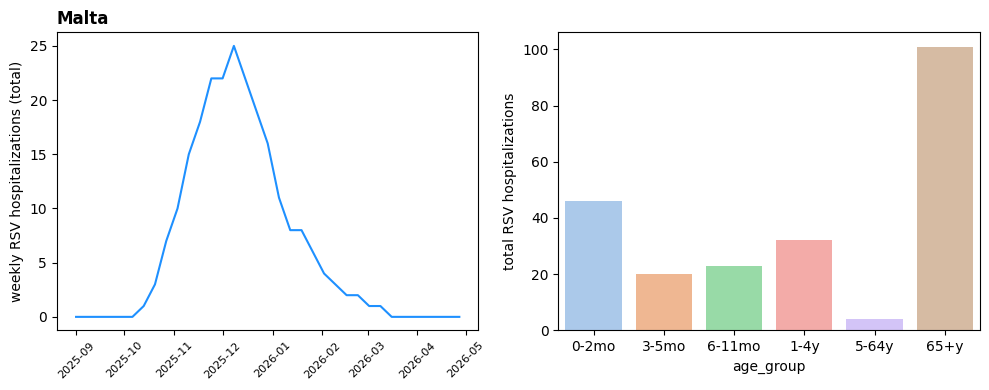

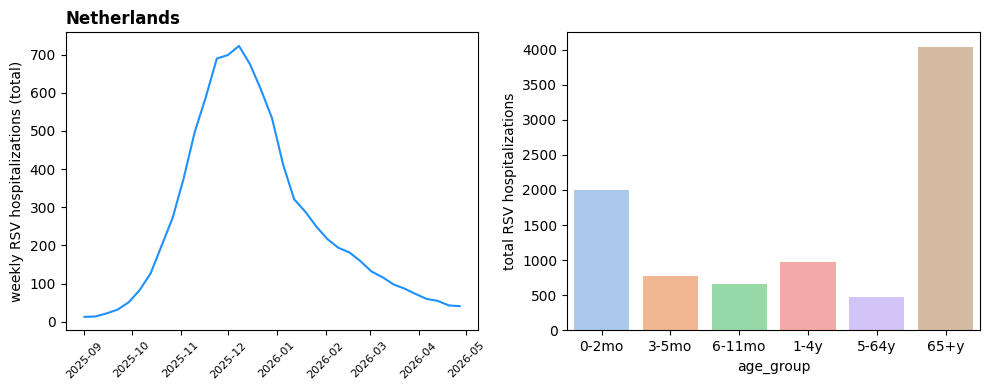

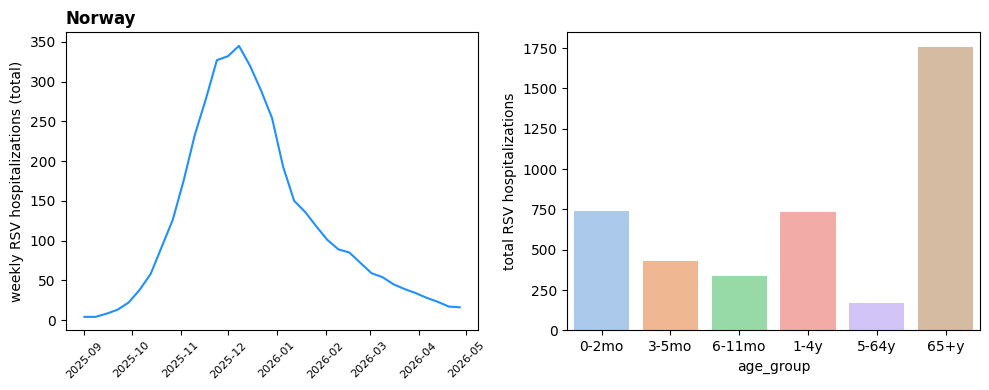

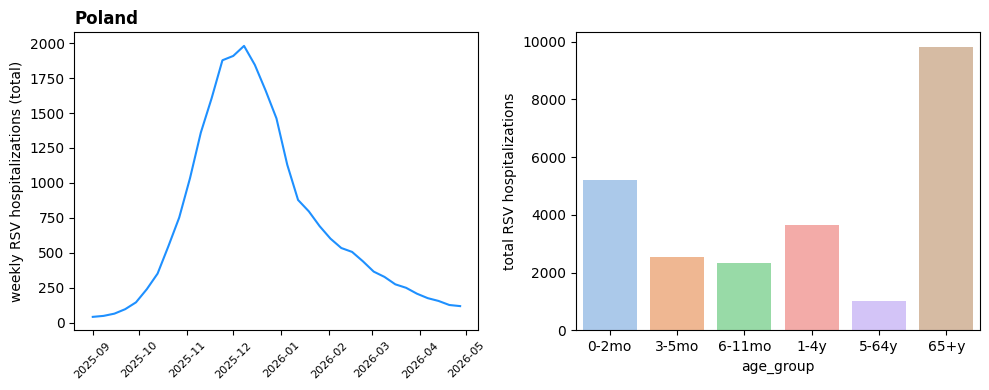

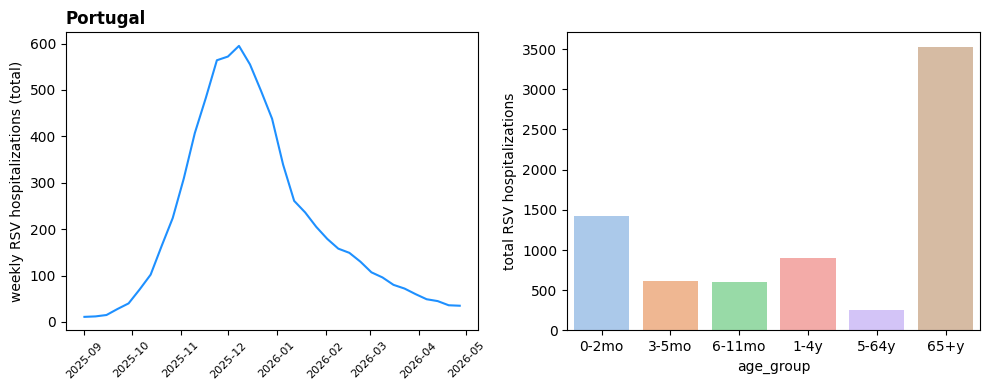

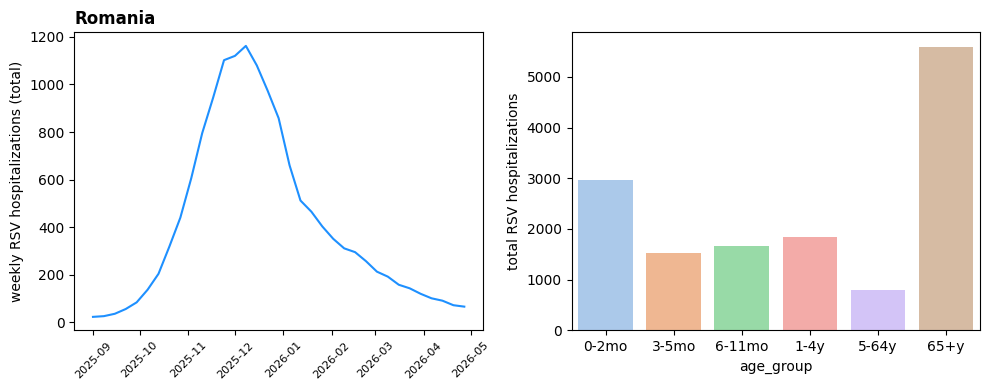

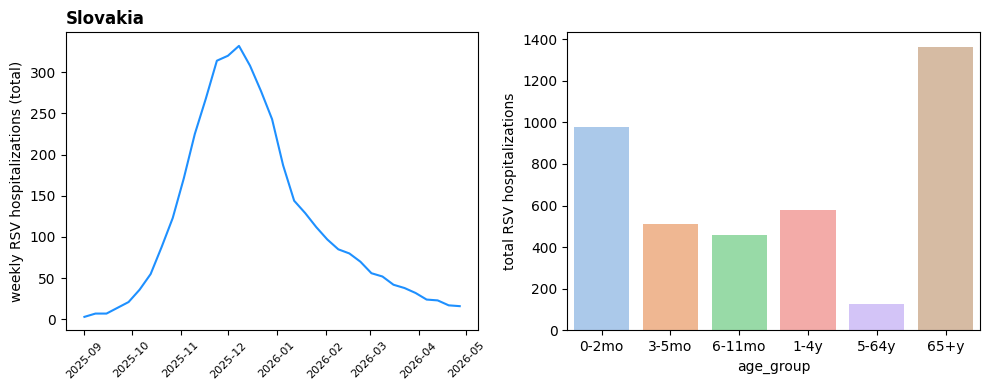

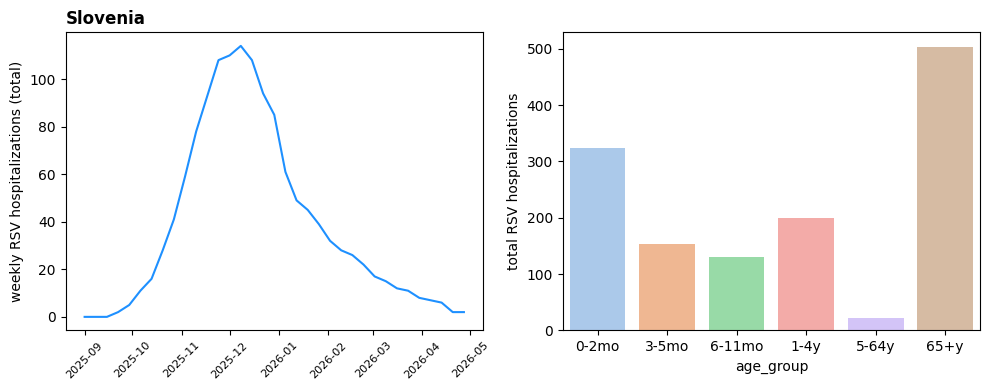

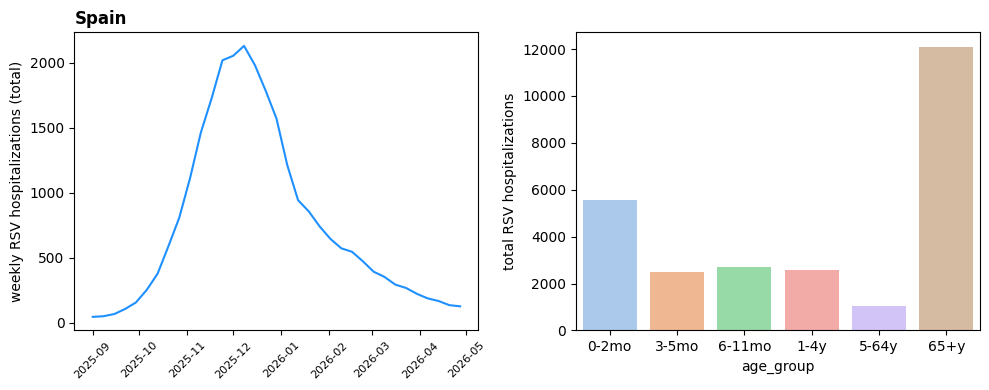

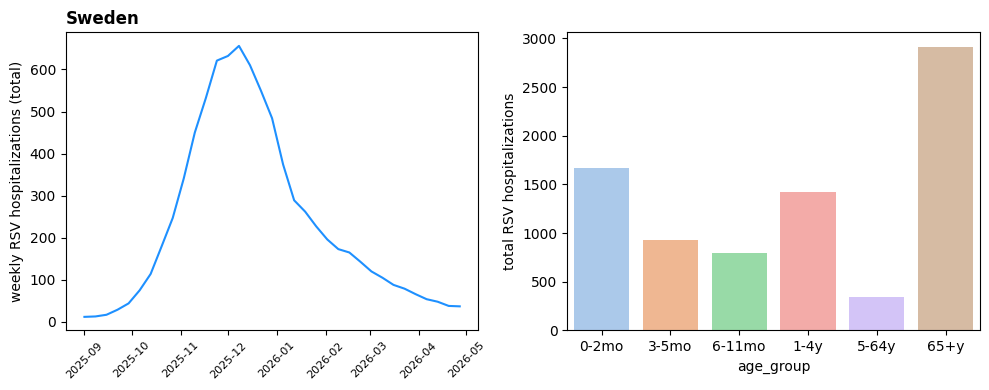

In [4]:
for country in countries_with_data: 
    df_weekly_country = df_weekly_hospitalizations.loc[df_weekly_hospitalizations.country == country]
    df_total_country = df_total_hospitalizations_ages.loc[df_total_hospitalizations_ages.country == country]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    axes[0].plot(df_weekly_country.date, df_weekly_country.hospitalizations, color="dodgerblue")
    axes[0].set_ylabel("weekly RSV hospitalizations (total)")
    axes[0].tick_params(axis='x', labelrotation=45, labelsize=8)

    sns.barplot(x="age_group", y="hospitalizations", data=df_total_country, ax=axes[1], palette="pastel")
    axes[1].set_ylabel("total RSV hospitalizations")
    axes[0].set_title(country, x=0, ha="left", weight="bold")
    plt.tight_layout()
    plt.show()


In [5]:
# save files
df_total_hospitalizations_ages.rename(columns={"hospitalizations": "total_rsv_hospitalisations"}, inplace=True)
df_total_hospitalizations_ages.insert(2, "start_date", df_weekly_hospitalizations.date.min())
df_total_hospitalizations_ages.insert(3, "end_date", df_weekly_hospitalizations.date.max())
df_total_hospitalizations_ages.to_csv("../hospitalburden_agegroups.csv", index=False)

df_weekly_hospitalizations.rename(columns={"hospitalizations": "weekly_rsv_hospitalisations"}, inplace=True)
df_weekly_hospitalizations.to_csv("../hospitaladmissions.csv", index=False)